<a href="https://colab.research.google.com/github/kausar-vento/UAS_BIG_DATA/blob/main/src/kode_skenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=12695183d664d2c884c24719326e2ed916063bd4f57ad6d47b8731d472260c62
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


+-----+--------+------------------+--------------------+
|tahun|features|        prediction|  prediction_percent|
+-----+--------+------------------+--------------------+
| 2024|[2024.0]|230320.74140419066|2.3032074140419066E7|
| 2025|[2025.0]| 240919.8286657296| 2.409198286657296E7|
| 2026|[2026.0]|251518.91592726484|2.5151891592726484E7|
| 2027|[2027.0]| 262118.0031888038| 2.621180031888038E7|
| 2028|[2028.0]|272717.09045034274|2.7271709045034274E7|
+-----+--------+------------------+--------------------+

Root Mean Squared Error (RMSE): 18286.67772854049
R-squared: 0.8133961787632602


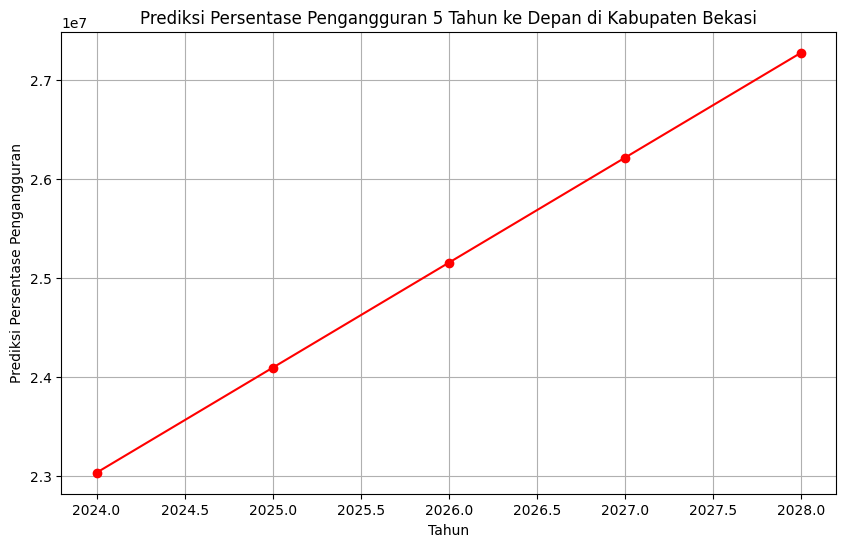

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName('UnemploymentPrediction').getOrCreate()

# Import dataset pengangguran
df = spark.read.csv('/content/drive/MyDrive/Big Data/data.csv', header=True, inferSchema=True)

# Filter dataset untuk Kabupaten Bekasi
df_bekasi = df.filter(df.nama_kabupaten_kota == 'KABUPATEN BEKASI')

# Grup berdasarkan Kabupaten Bekasi dan menghitung jumlahnya
df_bekasi_grouped = df_bekasi.groupBy('tahun').sum('jumlah_pengangguran').withColumnRenamed('sum(jumlah_pengangguran)', 'total_pengangguran')

# Preprocessing dataset
assembler = VectorAssembler(inputCols=['tahun'], outputCol='features')
df_bekasi_grouped = assembler.transform(df_bekasi_grouped)

# Membangun model regresi linear
lr = LinearRegression(featuresCol='features', labelCol='total_pengangguran')
model = lr.fit(df_bekasi_grouped)

# Prediksi jumlah pengangguran 5 tahun ke depan di Kabupaten Bekasi
future_data = spark.createDataFrame([(2024,), (2025,), (2026,), (2027,), (2028,)], ['tahun'])
future_data = assembler.transform(future_data)
future_predictions = model.transform(future_data)

# Mengubah hasil prediksi menjadi persentase
# Mengubah hasil prediksi menjadi persentase
future_predictions = future_predictions.withColumn('prediction_percent', future_predictions['prediction'] * 100)


# Menampilkan prediksi jumlah pengangguran 5 tahun ke depan di Kabupaten Bekasi
future_predictions.show()

# Prediksi akurasi model
summary = model.summary
print("Root Mean Squared Error (RMSE):", summary.rootMeanSquaredError)
print("R-squared:", summary.r2)

# Visualisasi hasil prediksi
tahun = future_predictions.select('tahun').rdd.flatMap(lambda x: x).collect()
prediction_percent = future_predictions.select('prediction_percent').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.plot(tahun, prediction_percent, color='red', marker='o')
plt.xlabel('Tahun')
plt.ylabel('Prediksi Persentase Pengangguran')
plt.title('Prediksi Persentase Pengangguran 5 Tahun ke Depan di Kabupaten Bekasi')
plt.grid(True)
plt.show()


+-----+-------------------+--------------------+
|tahun|nama_kabupaten_kota|  prediction_percent|
+-----+-------------------+--------------------+
| 2011|   KABUPATEN BEKASI|   9253260.700419918|
| 2012|   KABUPATEN BEKASI|1.0313169426573813E7|
| 2013|   KABUPATEN BEKASI|1.1373078152727708E7|
| 2014|   KABUPATEN BEKASI|1.2432986878881231E7|
| 2015|   KABUPATEN BEKASI|1.3492895605035126E7|
| 2017|   KABUPATEN BEKASI|1.5612713057342544E7|
| 2018|   KABUPATEN BEKASI| 1.667262178349644E7|
| 2019|   KABUPATEN BEKASI|1.7732530509650335E7|
| 2020|   KABUPATEN BEKASI|1.8792439235803857E7|
| 2021|   KABUPATEN BEKASI|1.9852347961957753E7|
| 2022|   KABUPATEN BEKASI|2.0912256688111648E7|
+-----+-------------------+--------------------+

Root Mean Squared Error (RMSE): 18286.677728540486
R-squared: 0.8133961787632602


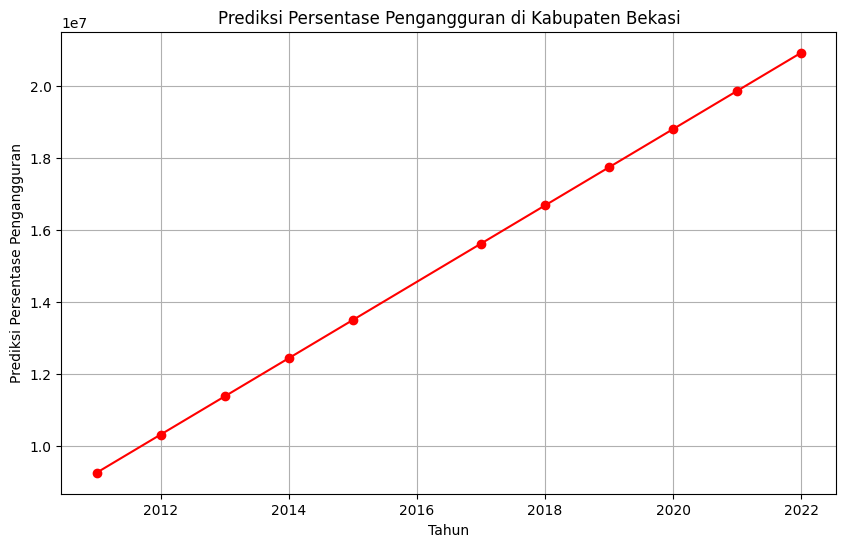

In [10]:
# Import dataset pengangguran
df = spark.read.csv('/content/drive/MyDrive/Big Data/data.csv', header=True, inferSchema=True)

# Filter dataset untuk Kabupaten Bekasi
df_bekasi = df.filter(df.nama_kabupaten_kota == 'KABUPATEN BEKASI')

# Grup berdasarkan Kabupaten Bekasi dan menghitung jumlahnya
df_bekasi_grouped = df_bekasi.groupBy('nama_kabupaten_kota', 'tahun').sum('jumlah_pengangguran').withColumnRenamed('sum(jumlah_pengangguran)', 'total_pengangguran')

# Preprocessing dataset
assembler = VectorAssembler(inputCols=['tahun'], outputCol='features')
df_bekasi_grouped = assembler.transform(df_bekasi_grouped)

# Membangun model regresi linear
lr = LinearRegression(featuresCol='features', labelCol='total_pengangguran')
model = lr.fit(df_bekasi_grouped)

# Prediksi jumlah pengangguran untuk setiap tahun
predictions = model.transform(df_bekasi_grouped)

# Mengubah hasil prediksi menjadi persentase
predictions = predictions.withColumn('prediction_percent', predictions['prediction'] * 100)

# Menampilkan prediksi jumlah pengangguran untuk setiap tahun di Kabupaten Bekasi
predictions_sorted = predictions.orderBy('tahun')
predictions_sorted.select('tahun', 'nama_kabupaten_kota', 'prediction_percent').show()

# Prediksi akurasi model
summary = model.summary
print("Root Mean Squared Error (RMSE):", summary.rootMeanSquaredError)
print("R-squared:", summary.r2)

# Visualisasi hasil prediksi
tahun = predictions_sorted.select('tahun').rdd.flatMap(lambda x: x).collect()
prediction_percent = predictions_sorted.select('prediction_percent').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.plot(tahun, prediction_percent, color='red', marker='o')
plt.xlabel('Tahun')
plt.ylabel('Prediksi Persentase Pengangguran')
plt.title('Prediksi Persentase Pengangguran di Kabupaten Bekasi')
plt.grid(True)
plt.show()
